In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import interpolate

In [47]:
train_eeg1_df = pd.read_csv('./raw/train_eeg1.csv')
train_eeg2_df = pd.read_csv('./raw/train_eeg2.csv')
train_emg_df = pd.read_csv('./raw/train_emg.csv')
y_train_df = pd.read_csv('./raw/train_labels.csv')

In [48]:
train_eeg1_df.head()

,Id,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x503,x504,x505,x506,x507,x508,x509,x510,x511,x512
0,0,0.000400,0.000470,0.000067,-0.00016,-0.000003,0.00031,0.000360,0.00019,-0.000072,...,-0.000086,0.000033,-0.000046,-0.000270,-0.000390,-0.00034,-0.00032,-0.00021,0.000042,0.000053
1,1,0.000067,0.000095,0.000270,0.00028,0.000250,0.00012,0.000094,-0.00034,-0.000960,...,0.000046,0.000300,0.000630,0.000710,0.000520,0.00041,0.00066,0.00088,0.000770,0.000410
2,2,0.000160,-0.000210,-0.000840,-0.00120,-0.001200,-0.00140,-0.001400,-0.00091,-0.000600,...,-0.000680,-0.000880,-0.001000,-0.000770,-0.000680,-0.00073,-0.00073,-0.00062,-0.000550,-0.000540
3,3,-0.000140,0.000260,0.000390,0.00043,0.000280,0.00023,0.000390,0.00022,0.000150,...,0.000720,0.000760,0.000380,0.000052,-0.000260,-0.00058,-0.00075,-0.00110,-0.001200,-0.001200
4,4,-0.001100,-0.000790,-0.000081,0.00014,0.000200,-0.00014,-0.000430,-0.00053,-0.000580,...,0.000290,0.000600,0.000670,0.000190,-0.000055,-0.00016,-0.00023,-0.00023,-0.000330,-0.000810


In [96]:
print(len(y_train_df[y_train_df['y'] == 1]))
print(len(y_train_df[y_train_df['y'] == 2]))
print(len(y_train_df[y_train_df['y'] == 3]))

34114
27133
3553


In [49]:
len(train_eeg1_df.iloc[0][1:])

512

In [55]:
x = np.array(train_eeg1_df.iloc[0][1:])
x = np.stack([x,x,x])
x = torch.Tensor(x)
x = x.unsqueeze(0)

In [56]:
x.shape

torch.Size([1, 3, 512])

In [57]:
conv = nn.Conv1d(in_channels=3, out_channels=32, kernel_size=5, stride=1)

conv_pad = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
drop_50 = nn.Dropout(p=0.5)

maxpool = nn.MaxPool1d(kernel_size=5, stride=2)

avgpool = nn.AdaptiveAvgPool1d(output_size=14)

dense1 = nn.Linear(32 * 14, 32)
dense2 = nn.Linear(32, 32)

dense_final = nn.Linear(32, 3)
        # self.softmax= nn.LogSoftmax(dim=1)

In [58]:

residual = conv(x)

# block1
x = F.relu(conv_pad(residual))
x = conv_pad(x)
x += residual
x = F.relu(x) # [batch_size 32 508]
residual = maxpool(x)  # [batch_size 32 252]
print(x.shape, '  ', residual.shape)

# block2
x = F.relu(conv_pad(residual))
x = conv_pad(x)
x += residual
x = F.relu(x) # [batch_size 32 252]
residual = maxpool(x) # [batch_size 32 124]
print(x.shape, '  ', residual.shape)

# block3
x = F.relu(conv_pad(residual))
x = conv_pad(x)
x += residual
x = F.relu(x)  # [batch_size 32 124]
residual = maxpool(x)  # [batch_size 32 60]
print(x.shape, '  ', residual.shape)

# block4
x = F.relu(conv_pad(residual))
x = conv_pad(x)
x += residual
x = F.relu(x)
x = maxpool(x)  # [batch_size 32 28]
print(x.shape, '  ', residual.shape)

torch.Size([1, 32, 508])    torch.Size([1, 32, 252])
torch.Size([1, 32, 252])    torch.Size([1, 32, 124])
torch.Size([1, 32, 124])    torch.Size([1, 32, 60])
torch.Size([1, 32, 28])    torch.Size([1, 32, 60])


In [59]:
len(train_eeg1_df)

64800

In [60]:
len(y_train_df)

64800

In [61]:
considered_signal = np.array(train_eeg1_df.drop('Id', axis=1).iloc[0])                                             

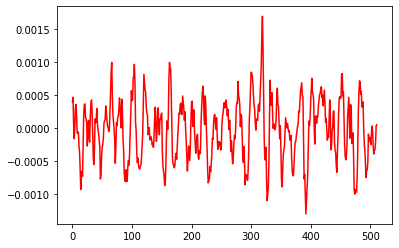

In [62]:
plt.plot(np.arange(len(considered_signal)), considered_signal, '-r')

In [63]:
y_train_df.head()

,Id,y
0,0,2
1,1,2
2,2,2
3,3,2
4,4,2


# emg signal

In [88]:
train_emg_df.head()

,Id,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x503,x504,x505,x506,x507,x508,x509,x510,x511,x512
0,0,-0.000024,-0.000018,-0.000014,-0.000017,-0.000012,-0.000007,-0.000004,-0.000009,-0.000060,...,-0.000003,-0.000009,-0.000010,-0.000002,-9.000000e-07,-0.000010,-0.000006,-0.000013,-0.000030,-0.000004
1,1,-0.000005,-0.000007,-0.000007,-0.000008,-0.000006,-0.000008,-0.000012,-0.000017,-0.000015,...,-0.000014,-0.000016,-0.000010,-0.000005,-9.200000e-06,-0.000011,-0.000010,-0.000015,0.000006,-0.000006
2,2,-0.000013,-0.000013,-0.000008,-0.000014,-0.000005,-0.000008,-0.000011,-0.000007,-0.000008,...,-0.000005,-0.000008,-0.000011,-0.000014,-1.800000e-05,-0.000012,-0.000015,-0.000015,-0.000016,-0.000011
3,3,-0.000011,-0.000010,-0.000029,-0.000041,-0.000010,-0.000021,-0.000010,-0.000012,-0.000005,...,0.000019,-0.000012,-0.000009,-0.000011,-6.400000e-06,-0.000012,-0.000008,-0.000007,-0.000003,-0.000014
4,4,-0.000011,-0.000014,-0.000010,-0.000011,-0.000004,-0.000051,-0.000029,-0.000002,-0.000011,...,-0.000033,-0.000005,-0.000008,-0.000011,-1.200000e-05,-0.000008,-0.000008,-0.000007,-0.000011,-0.000007


In [92]:
my_emg_signal = train_emg_df.drop('Id', axis=1).values.reshape(-1)
my_emg_signal = my_emg_signal[:int(len(my_emg_signal)/3)]

In [85]:
considered_emg = np.array(train_emg_df.drop('Id', axis=1).iloc[0])   

In [271]:
np.where((my_emg_signal < 0.001) & (my_emg_signal > -0.001))[0]

array([       0,        1,        2, ..., 11059197, 11059198, 11059199])

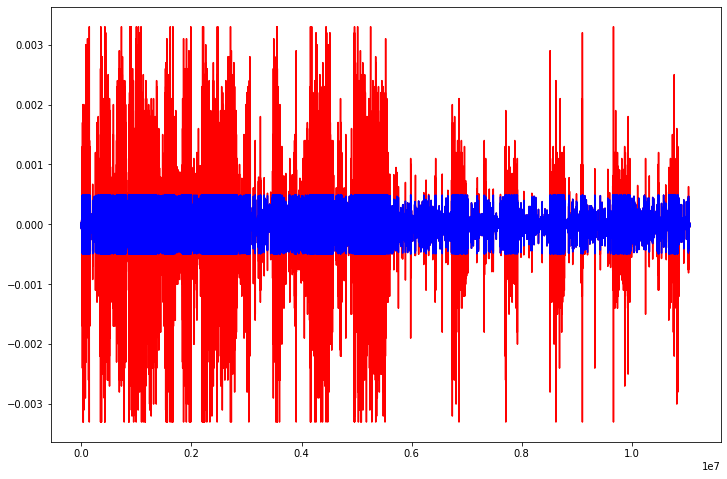

In [273]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(len(my_emg_signal)), my_emg_signal, '-r')
plt.plot(np.where((my_emg_signal < 0.0005) & (my_emg_signal > -0.0005))[0],
         my_emg_signal[np.where((my_emg_signal < 0.0005) & (my_emg_signal > -0.0005))[0]], '-b')

In [94]:
y_train_df

,Id,y
0,0,2
1,1,2
2,2,2
3,3,2
4,4,2
...,...,...
64795,64795,1
64796,64796,1
64797,64797,1
64798,64798,1


# feature extraction

In [64]:
import biosppy
from biosppy.signals import eeg, emg

In [65]:
considered_signal = considered_signal.reshape(512,1)

In [66]:
ts, filtered, features_ts, theta, alpha_low, alpha_high, beta, gamma, plf_pairs, plf = eeg.eeg(considered_signal, sampling_rate=128, show=False)

In [67]:
considered_signal_emg = np.array(train_emg_df.drop('Id', axis=1).iloc[0])     

In [68]:
filtered.shape

(512, 1)

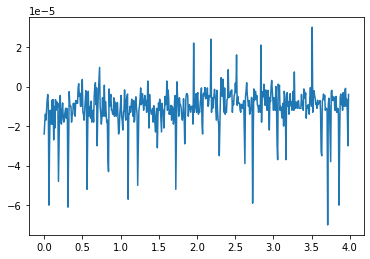

In [69]:
plt.plot(ts,considered_signal_emg)

In [70]:
theta.shape

(31, 1)

In [71]:
# IDEA:
# we have 21600 epochs for a patient, maybe we can use the state of 100 epochs
# we can use the frequency analysis again

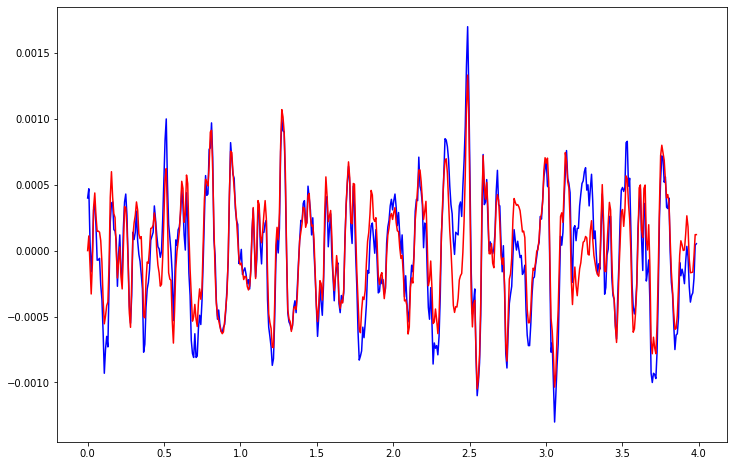

In [74]:
plt.figure(figsize=(12,8))
plt.plot(ts, considered_signal.reshape(512,), '-b')
plt.plot(ts, filtered.reshape(512,), '-r')

In [17]:
len(train_eeg1_df.iloc[:21600])

21600

In [18]:
patient1 = train_eeg1_df.drop('Id', axis=1).iloc[:21600].values.reshape(21600*512,1)

In [97]:
from scipy import signal

In [235]:
considered_signal = np.array(train_eeg1_df.drop('Id', axis=1).iloc[0])                                             

In [236]:
considered_signal = considered_signal.reshape(512,1)

In [237]:
ts, filtered, features_ts, theta, alpha_low, alpha_high, beta, gamma, plf_pairs, plf = eeg.eeg(considered_signal, sampling_rate=128, show=False)

In [238]:
freqs, psd = signal.welch(filtered.reshape(512,), fs=1)

In [239]:
freqs.shape

(129,)

In [240]:
psd.shape

(129,)

In [241]:
correlation = np.correlate(filtered.reshape(512,),filtered.reshape(512,),"full")

In [242]:
correlation.shape

(1023,)

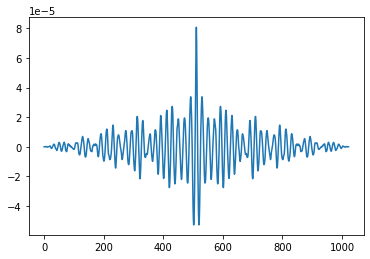

In [243]:
plt.plot(np.arange(len(correlation)), correlation)

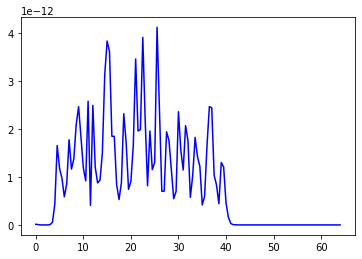

In [218]:
plt.plot(freqs, psd, '-b')

In [409]:
considered_signal_emg = np.array(train_emg_df.drop('Id', axis=1).iloc[41])  
#considered_signal_emg = considered_signal_emg.reshape(512,1)

In [410]:
ts_emg, filtered_emg, onsets_emg = emg.emg(considered_signal_emg, show=False)

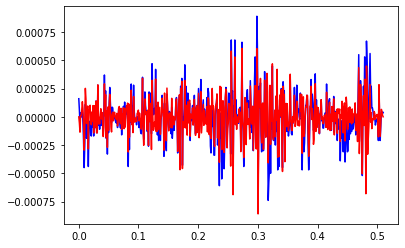

In [411]:
plt.plot(ts_emg.reshape(512,), considered_signal_emg.reshape(512,), 'b')
plt.plot(ts_emg.reshape(512,), filtered_emg.reshape(512,), 'r')

In [412]:
onsets_emg

array([], dtype=int64)

In [413]:
len(onsets_emg)

0

In [294]:
my_emg_signal

array([-2.4e-05, -1.8e-05, -1.4e-05, ..., -1.2e-05, -2.6e-06, -7.9e-06])

In [357]:
ts_emg_all, filtered_emg_all, onsets_emg_all = emg.emg(my_emg_signal, show=False)

In [296]:
len(onsets_emg_all)

13287

In [377]:
np.array(onsets_emg_all/512, dtype=int)[:30]

array([34, 34, 35, 35, 35, 35, 37, 37, 38, 38, 38, 39, 39, 39, 40, 40, 41,
       41, 41, 41, 42, 42, 44, 44, 44, 44, 44, 44, 52, 53])

In [311]:
onset_df=y_train_df.iloc[np.array(onsets_emg_all/512, dtype=int)]

In [312]:
print(len(onset_df[onset_df['y'] == 1]))
print(len(onset_df[onset_df['y'] == 2]))
print(len(onset_df[onset_df['y'] == 3]))

13287
0
0


In [321]:
print(len(y_train_df[y_train_df['y'] == 1]))
print(len(y_train_df[y_train_df['y'] == 2]))
print(len(y_train_df[y_train_df['y'] == 3]))

34114
27133
3553


In [340]:
eeg1_df = train_eeg1_df.drop('Id', axis=1).head(50)

In [342]:
import time

In [343]:
start = time.time()
values_eeg1 = eeg1_df.apply(lambda x: eeg.eeg(np.array(x).reshape(512,1), sampling_rate=128, show=False), axis=1)
end = time.time()

print(end-start)

0.5064980983734131


In [347]:
values_eeg1[0]['filtered']

array([[ 9.65714633e-07],
       [ 1.12120918e-04],
       [-1.14580142e-04],
       [-3.28260848e-04],
       [-9.49000280e-05],
       [ 3.28293849e-04],
       [ 4.38225189e-04],
       [ 2.63992769e-04],
       [ 1.46928811e-04],
       [ 1.49313725e-04],
       [ 1.39895937e-04],
       [ 7.63654203e-05],
       [-8.99078743e-05],
       [-3.72739036e-04],
       [-5.54748382e-04],
       [-4.95852080e-04],
       [-4.16212953e-04],
       [-3.89528805e-04],
       [-1.02782969e-04],
       [ 4.05586710e-04],
       [ 5.99581690e-04],
       [ 4.03928228e-04],
       [ 2.81620104e-04],
       [ 2.51515565e-04],
       [ 7.71696533e-06],
       [-2.07229485e-04],
       [-7.29205183e-05],
       [ 2.88051660e-05],
       [-1.99058226e-04],
       [-2.89912735e-04],
       [ 3.57166161e-05],
       [ 3.34780058e-04],
       [ 3.26346546e-04],
       [ 1.80697034e-04],
       [-8.84650691e-05],
       [-4.72336080e-04],
       [-5.81369696e-04],
       [-2.46218901e-04],
       [ 1.1

# testing features

In [61]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import balanced_accuracy_score
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.svm import SVC, NuSVC

from sklearn.multiclass import OneVsRestClassifier

In [62]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest

from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler
from sklearn.ensemble import IsolationForest

from sklearn.decomposition import PCA

In [63]:
## SPLIT FUNCTIONS FOR CV ##

def split_df(df, n) :
    '''
    df: dataframe to shuffle and split
    n: amount of to be splitted pieces
    splits: list of dataframes (splits)
    '''
    # defining list with optimal cutting points
    split_points = list(map( lambda x: int(x*len(df)/n), (list(range(1,n)))))  
    # shuffling the df, then splitting it from split_points
    splits = list(np.split(df.sample(frac=1), split_points))
    return splits

def make_train_and_test(splits, index) :
    '''
    Take splits from splitDf, and return into test set (splits[index])
    and training set (the rest)
    '''
    
    # index is zero based, so range 0-9 for 10 fold split
    test = splits[index]

    left_lst = splits[:index]
    right_lst = splits[index+1:]

    train = pd.concat(left_lst+right_lst)
    return train, test

In [422]:
features_train_50 = pd.read_csv('./sklearn_models/features/features_train_50.csv')

In [423]:
features_train_50.head()

,mean_eeg1,min_eeg1,max_eeg1,std_eeg1,median_eeg1,mean_eeg2,min_eeg2,max_eeg2,std_eeg2,median_eeg2,...,corr_max_2_eeg2,corr_min_2_eeg1,corr_min_2_eeg2,corr1_2_eeg1,corr1_2_eeg2,corr2_2_eeg1,corr2_2_eeg2,corr3_2_eeg1,corr3_2_eeg2,consists_emg_onset
0,-5.349145e-07,-0.001048,0.001333,0.000397,0.000002,0.000001,-0.000819,0.001288,0.000360,-0.000011,...,0.000066,-0.000053,-0.000046,0.035597,0.038000,-0.002144,0.009919,0.024656,0.008888,0
1,5.238850e-06,-0.001115,0.001248,0.000444,-0.000034,0.000003,-0.000970,0.001331,0.000357,-0.000007,...,0.000065,-0.000060,-0.000039,-0.030121,-0.049730,-0.008806,-0.015336,0.012618,-0.004675,0
2,-8.900721e-06,-0.001174,0.001313,0.000459,-0.000052,-0.000007,-0.001097,0.001089,0.000394,-0.000041,...,0.000080,-0.000061,-0.000046,-0.018091,-0.001299,-0.058309,-0.071767,-0.020808,-0.038337,0
3,7.052108e-06,-0.001073,0.001597,0.000450,-0.000012,0.000008,-0.001044,0.001467,0.000428,-0.000025,...,0.000094,-0.000055,-0.000054,0.008554,-0.007510,0.001513,0.029931,-0.048247,-0.046283,0
4,3.591152e-06,-0.001163,0.001224,0.000460,-0.000038,0.000003,-0.001006,0.001072,0.000436,-0.000033,...,0.000097,-0.000076,-0.000067,0.002172,-0.007226,-0.044430,-0.065203,-0.025181,-0.031156,0


In [60]:
print(len(features_train_50))
print(len(features_train_50[features_train_50['consists_emg_onset'] == 1]))

64800
11632


In [82]:
train_df = pd.concat([features_train_50, y_train_df], axis=1)
splits = split_df(train_df, 5)
train, test = make_train_and_test(splits, 0)
X_tr = train.drop(['Id', 'y'], axis=1).to_numpy()
y_tr = train['y'].to_numpy()
y_tr = y_tr-1
X_te = test.drop(['Id', 'y'], axis=1).to_numpy()
y_te = test['y'].to_numpy()
y_te = y_te-1

In [83]:
def isof(x, y):
    model = IsolationForest()
    y_pred = model.fit_predict(x)
    return x[y_pred == 1], y[y_pred == 1]

In [84]:
from sklearn.feature_selection import VarianceThreshold, GenericUnivariateSelect

In [85]:
thresh = VarianceThreshold(threshold=0)
X_tr = thresh.fit_transform(X_tr)

In [86]:
X_tr, y_tr = isof(X_tr, y_tr)

In [87]:
#-------------------

In [88]:
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler()
X_tr, y_tr = sampler.fit_resample(X_tr, y_tr)

In [89]:
#from imblearn.over_sampling import RandomOverSampler
#sampler = RandomOverSampler()
#X_tr, y_tr = sampler.fit_resample(X_tr, y_tr)

In [90]:
#from imblearn.combine import SMOTEENN, SMOTETomek
#sampler = SMOTEENN()
#X_tr, y_tr = sampler.fit_resample(X_tr, y_tr)

In [91]:
#-------------------

In [92]:
selection = GenericUnivariateSelect(mode='fdr', param=0.1)#, param=0.1, mode='fwe')
X_tr = selection.fit_transform(X_tr, y_tr)

In [93]:
scale = StandardScaler()
X_tr = scale.fit_transform(X_tr)

In [94]:
param_grid_xgb = [
    {
        'estimator__max_depth':[3]
    }
]

In [95]:
# initial test XGBClassifier
clf = OneVsRestClassifier(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                                colsample_bynode=1, colsample_bytree=1, gamma=0,
                                importance_type='gain', learning_rate=0.1, max_delta_step=0,
                                max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                                n_jobs=1, nthread=None, random_state=0,
                                reg_alpha=0, reg_lambda=1, seed=None,
                                silent=None, subsample=1, verbosity=1))
search = GridSearchCV(clf, param_grid=param_grid_xgb, n_jobs=-1, scoring='balanced_accuracy', cv=3, verbose=10)

In [96]:
search.fit(X_tr, y_tr)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s finished


GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5,
                                                                   booster='gbtree',
                                                                   colsample_bylevel=1,
                                                                   colsample_bynode=1,
                                                                   colsample_bytree=1,
                                                                   gamma=0,
                                                                   gpu_id=None,
                                                                   importance_type='gain',
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.1,
                                                                   max_delta_step=0,
                                    

In [97]:
print('Best', search.scoring, 'score: ', search.best_score_)
print("Best parameters set:", search.best_params_)

Best balanced_accuracy score:  0.9358024691358025
Best parameters set: {'estimator__max_depth': 3}


In [98]:
from sklearn.metrics import balanced_accuracy_score

X_te = thresh.transform(X_te)
X_te = selection.transform(X_te)
X_te = scale.transform(X_te)

predicted = search.predict(X_te)
test_score = balanced_accuracy_score(y_te, predicted)
print('Test BMAC: {}'.format(test_score))

Test BMAC: 0.940035356482912


# -- create sub file --

In [101]:
features_test_50 = pd.read_csv('./sklearn_models/features/features_test_50.csv')

In [102]:
features_test_50.head()

,mean_eeg1,min_eeg1,max_eeg1,std_eeg1,median_eeg1,mean_eeg2,min_eeg2,max_eeg2,std_eeg2,median_eeg2,...,corr_max_2_eeg2,corr_min_2_eeg1,corr_min_2_eeg2,corr1_2_eeg1,corr1_2_eeg2,corr2_2_eeg1,corr2_2_eeg2,corr3_2_eeg1,corr3_2_eeg2,consists_emg_onset
0,0.000002,-0.000934,0.000964,0.000328,0.000014,1.886587e-07,-0.000895,0.000927,0.000312,0.000001,...,0.000050,-0.000033,-0.000027,-0.010201,-0.033260,0.001880,0.025034,0.001727,-0.008683,0
1,0.000006,-0.000832,0.001033,0.000349,0.000002,2.871827e-06,-0.001220,0.000972,0.000320,0.000003,...,0.000052,-0.000031,-0.000024,-0.011701,-0.003912,0.019401,-0.009471,-0.009203,-0.000688,0
2,-0.000002,-0.001041,0.000935,0.000317,0.000002,-2.297048e-06,-0.000733,0.000928,0.000296,-0.000012,...,0.000045,-0.000026,-0.000018,0.014712,0.074491,0.039002,-0.006610,-0.044213,-0.024358,0
3,0.000008,-0.001109,0.000829,0.000318,0.000006,2.462336e-06,-0.001177,0.001146,0.000293,-0.000016,...,0.000044,-0.000025,-0.000020,-0.013848,0.010276,0.014624,-0.014965,0.006360,-0.010876,0
4,-0.000003,-0.000964,0.001041,0.000393,0.000006,-5.428621e-06,-0.001090,0.001073,0.000381,0.000002,...,0.000074,-0.000043,-0.000040,0.037298,0.005154,0.001067,0.010386,-0.022883,-0.032827,0


In [103]:
print(len(features_test_50))
print(len(features_test_50[features_test_50['consists_emg_onset'] == 1]))

43200
8071


In [104]:
X_sub = features_test_50.to_numpy()

In [105]:
print(X_sub.shape)
X_sub = thresh.transform(X_sub)
X_sub = selection.transform(X_sub)
X_sub = scale.transform(X_sub)
print(X_sub.shape)

(43200, 50)
(43200, 45)


In [106]:
submissions = search.predict(X_sub)
submissions = submissions+1

In [107]:
print(len(np.where(submissions == 1)[0]))
print(len(np.where(submissions == 2)[0]))
print(len(np.where(submissions == 3)[0]))

19653
21065
2482


In [108]:
submissions

array([1, 1, 1, ..., 1, 1, 1])

In [111]:
sample_df = pd.read_csv('./raw/sample.csv')

In [115]:
#submissions = pd.DataFrame(submissions)
#submissions.to_csv('./predictions/prediction_init.csv', index_label='Id', header=['y'], compression=None)